In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Dataset ── updated URL
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# ham=0, spam=1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Quick inspection (same as your df.head())
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts(normalize=True))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  label                                            message  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0

Label distribution:
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


In [5]:
def clean_text(text):
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Lowercase and split
    words = text.lower().split()
    # Remove stopwords
    clean_words = [w for w in words if w not in stop_words]
    return " ".join(clean_words)

df['clean_msg'] = df['message'].apply(clean_text)
print("Original:", df['message'][2])
print("Cleaned:", df['clean_msg'][2])

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Cleaned: free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_msg'], df['label_num'], test_size=0.2, random_state=42)

# Define vectorizers and models
vectorizers = {
    'CountVec': CountVectorizer(),
    'TF-IDF': TfidfVectorizer()
}

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='linear')
}

results = []

for v_name, v_obj in vectorizers.items():
    # Transform data
    X_train_vec = v_obj.fit_transform(X_train)
    X_test_vec = v_obj.transform(X_test)
    
    for m_name, m_obj in models.items():
        # Train and Predict
        m_obj.fit(X_train_vec, y_train)
        preds = m_obj.predict(X_test_vec)
        
        # Evaluate
        acc = accuracy_score(y_test, preds)
        results.append({'Vectorizer': v_name, 'Model': m_name, 'Accuracy': acc})
        
        print(f"--- {v_name} + {m_name} ---")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, preds))

--- CountVec + Naive Bayes ---
Accuracy: 0.9839
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.94      0.94      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115

--- CountVec + Logistic Regression ---
Accuracy: 0.9865
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.90      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

--- CountVec + SVM ---
Accuracy: 0.9857
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.91      0.94       149

    accuracy                          

  Vectorizer                Model  Accuracy
5     TF-IDF                  SVM  0.991031
1   CountVec  Logistic Regression  0.986547
2   CountVec                  SVM  0.985650
0   CountVec          Naive Bayes  0.983857
3     TF-IDF          Naive Bayes  0.974888
4     TF-IDF  Logistic Regression  0.968610


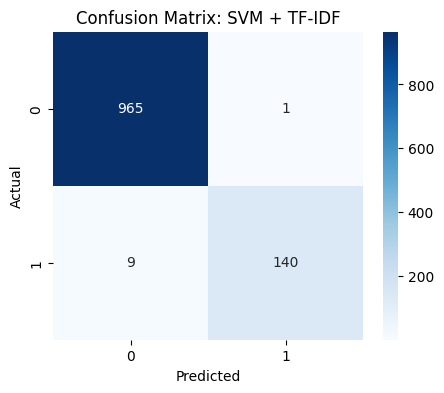

In [7]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

# Confusion Matrix for the last model run (SVM/TF-IDF usually performs well)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: SVM + TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()